Reference:
1. [Feature Engineering Techniques](https://www.kaggle.com/c/ieee-fraud-detection/discussion/108575)

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('/kaggle/input/tabular-playground-series-may-2021'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-may-2021/test.csv
/kaggle/input/tabular-playground-series-may-2021/train.csv
/kaggle/input/tabular-playground-series-may-2021/sample_submission.csv


In [8]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from colorama import Fore

from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import metrics
from scipy import stats
import math

from tqdm.notebook import tqdm
from copy import deepcopy

from sklearn.preprocessing import LabelEncoder

from umap import UMAP
from sklearn.manifold import TSNE

pd.set_option("display.max_columns", 999)

In [20]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

plt.rcParams['axes.facecolor'] = primary_bgcolor

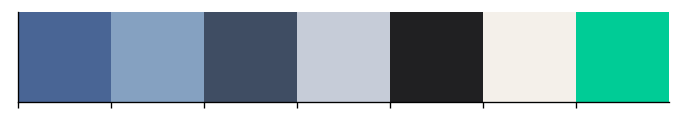

In [21]:
colors = [primary_blue, primary_blue2, primary_blue3, primary_grey, primary_black, primary_bgcolor, primary_green]
sns.palplot(sns.color_palette(colors))

In [13]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.family'] = 'serif'

In [10]:
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-may-2021/train.csv')
train_df.columns = [column.lower() for column in train_df.columns]

test_df = pd.read_csv('/kaggle/input/tabular-playground-series-may-2021/test.csv')
test_df.columns = [column.lower() for column in test_df.columns]

submission = pd.read_csv('/kaggle/input/tabular-playground-series-may-2021/sample_submission.csv')


In [14]:
feature_columns = train_df.iloc[:, 1:-1].columns.values
target_column = 'target'
feature_columns

array(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13',
       'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'feature_19', 'feature_20', 'feature_21',
       'feature_22', 'feature_23', 'feature_24', 'feature_25',
       'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33',
       'feature_34', 'feature_35', 'feature_36', 'feature_37',
       'feature_38', 'feature_39', 'feature_40', 'feature_41',
       'feature_42', 'feature_43', 'feature_44', 'feature_45',
       'feature_46', 'feature_47', 'feature_48', 'feature_49'],
      dtype=object)

In [15]:
print(train_df.shape)
print(test_df.shape)

(100000, 52)
(50000, 51)


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          100000 non-null  int64 
 1   feature_0   100000 non-null  int64 
 2   feature_1   100000 non-null  int64 
 3   feature_2   100000 non-null  int64 
 4   feature_3   100000 non-null  int64 
 5   feature_4   100000 non-null  int64 
 6   feature_5   100000 non-null  int64 
 7   feature_6   100000 non-null  int64 
 8   feature_7   100000 non-null  int64 
 9   feature_8   100000 non-null  int64 
 10  feature_9   100000 non-null  int64 
 11  feature_10  100000 non-null  int64 
 12  feature_11  100000 non-null  int64 
 13  feature_12  100000 non-null  int64 
 14  feature_13  100000 non-null  int64 
 15  feature_14  100000 non-null  int64 
 16  feature_15  100000 non-null  int64 
 17  feature_16  100000 non-null  int64 
 18  feature_17  100000 non-null  int64 
 19  feature_18  100000 non-n

In [17]:
fig = px.histogram(
    train_df, 
    x=target_column, 
    color=target_column,
    color_discrete_sequence=px.colors.qualitative.G10,
)
fig.update_layout(
    title_text='Target distribution', # title of plot
    xaxis_title_text='Value', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    paper_bgcolor=primary_bgcolor,
    plot_bgcolor=primary_bgcolor,
)
fig.update_xaxes(
    title='Target class',
    categoryorder='category ascending',
)
fig.show()

In [18]:
train_df.drop(columns=['id']).describe().T\
        .style.bar(subset=['mean'], color=px.colors.qualitative.G10[0])\
        .background_gradient(subset=['std'], cmap='Greens')\
        .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
feature_0,100000.000000,0.257830,0.929033,0.000000,0.000000,0.000000,0.000000,10.000000
feature_1,100000.000000,0.431720,1.977862,0.000000,0.000000,0.000000,0.000000,31.000000
feature_2,100000.000000,0.114130,0.519584,0.000000,0.000000,0.000000,0.000000,6.000000
feature_3,100000.000000,0.590550,1.844558,0.000000,0.000000,0.000000,0.000000,26.000000
feature_4,100000.000000,0.599770,2.785531,0.000000,0.000000,0.000000,0.000000,38.000000
feature_5,100000.000000,0.160820,0.601149,0.000000,0.000000,0.000000,0.000000,10.000000
feature_6,100000.000000,0.731490,2.343465,0.000000,0.000000,0.000000,0.000000,27.000000
feature_7,100000.000000,1.228920,2.692732,0.000000,0.000000,0.000000,1.000000,31.000000
feature_8,100000.000000,0.903350,3.415258,0.000000,0.000000,0.000000,0.000000,39.000000
feature_9,100000.000000,0.940120,1.904172,0.000000,0.000000,0.000000,1.000000,17.000000


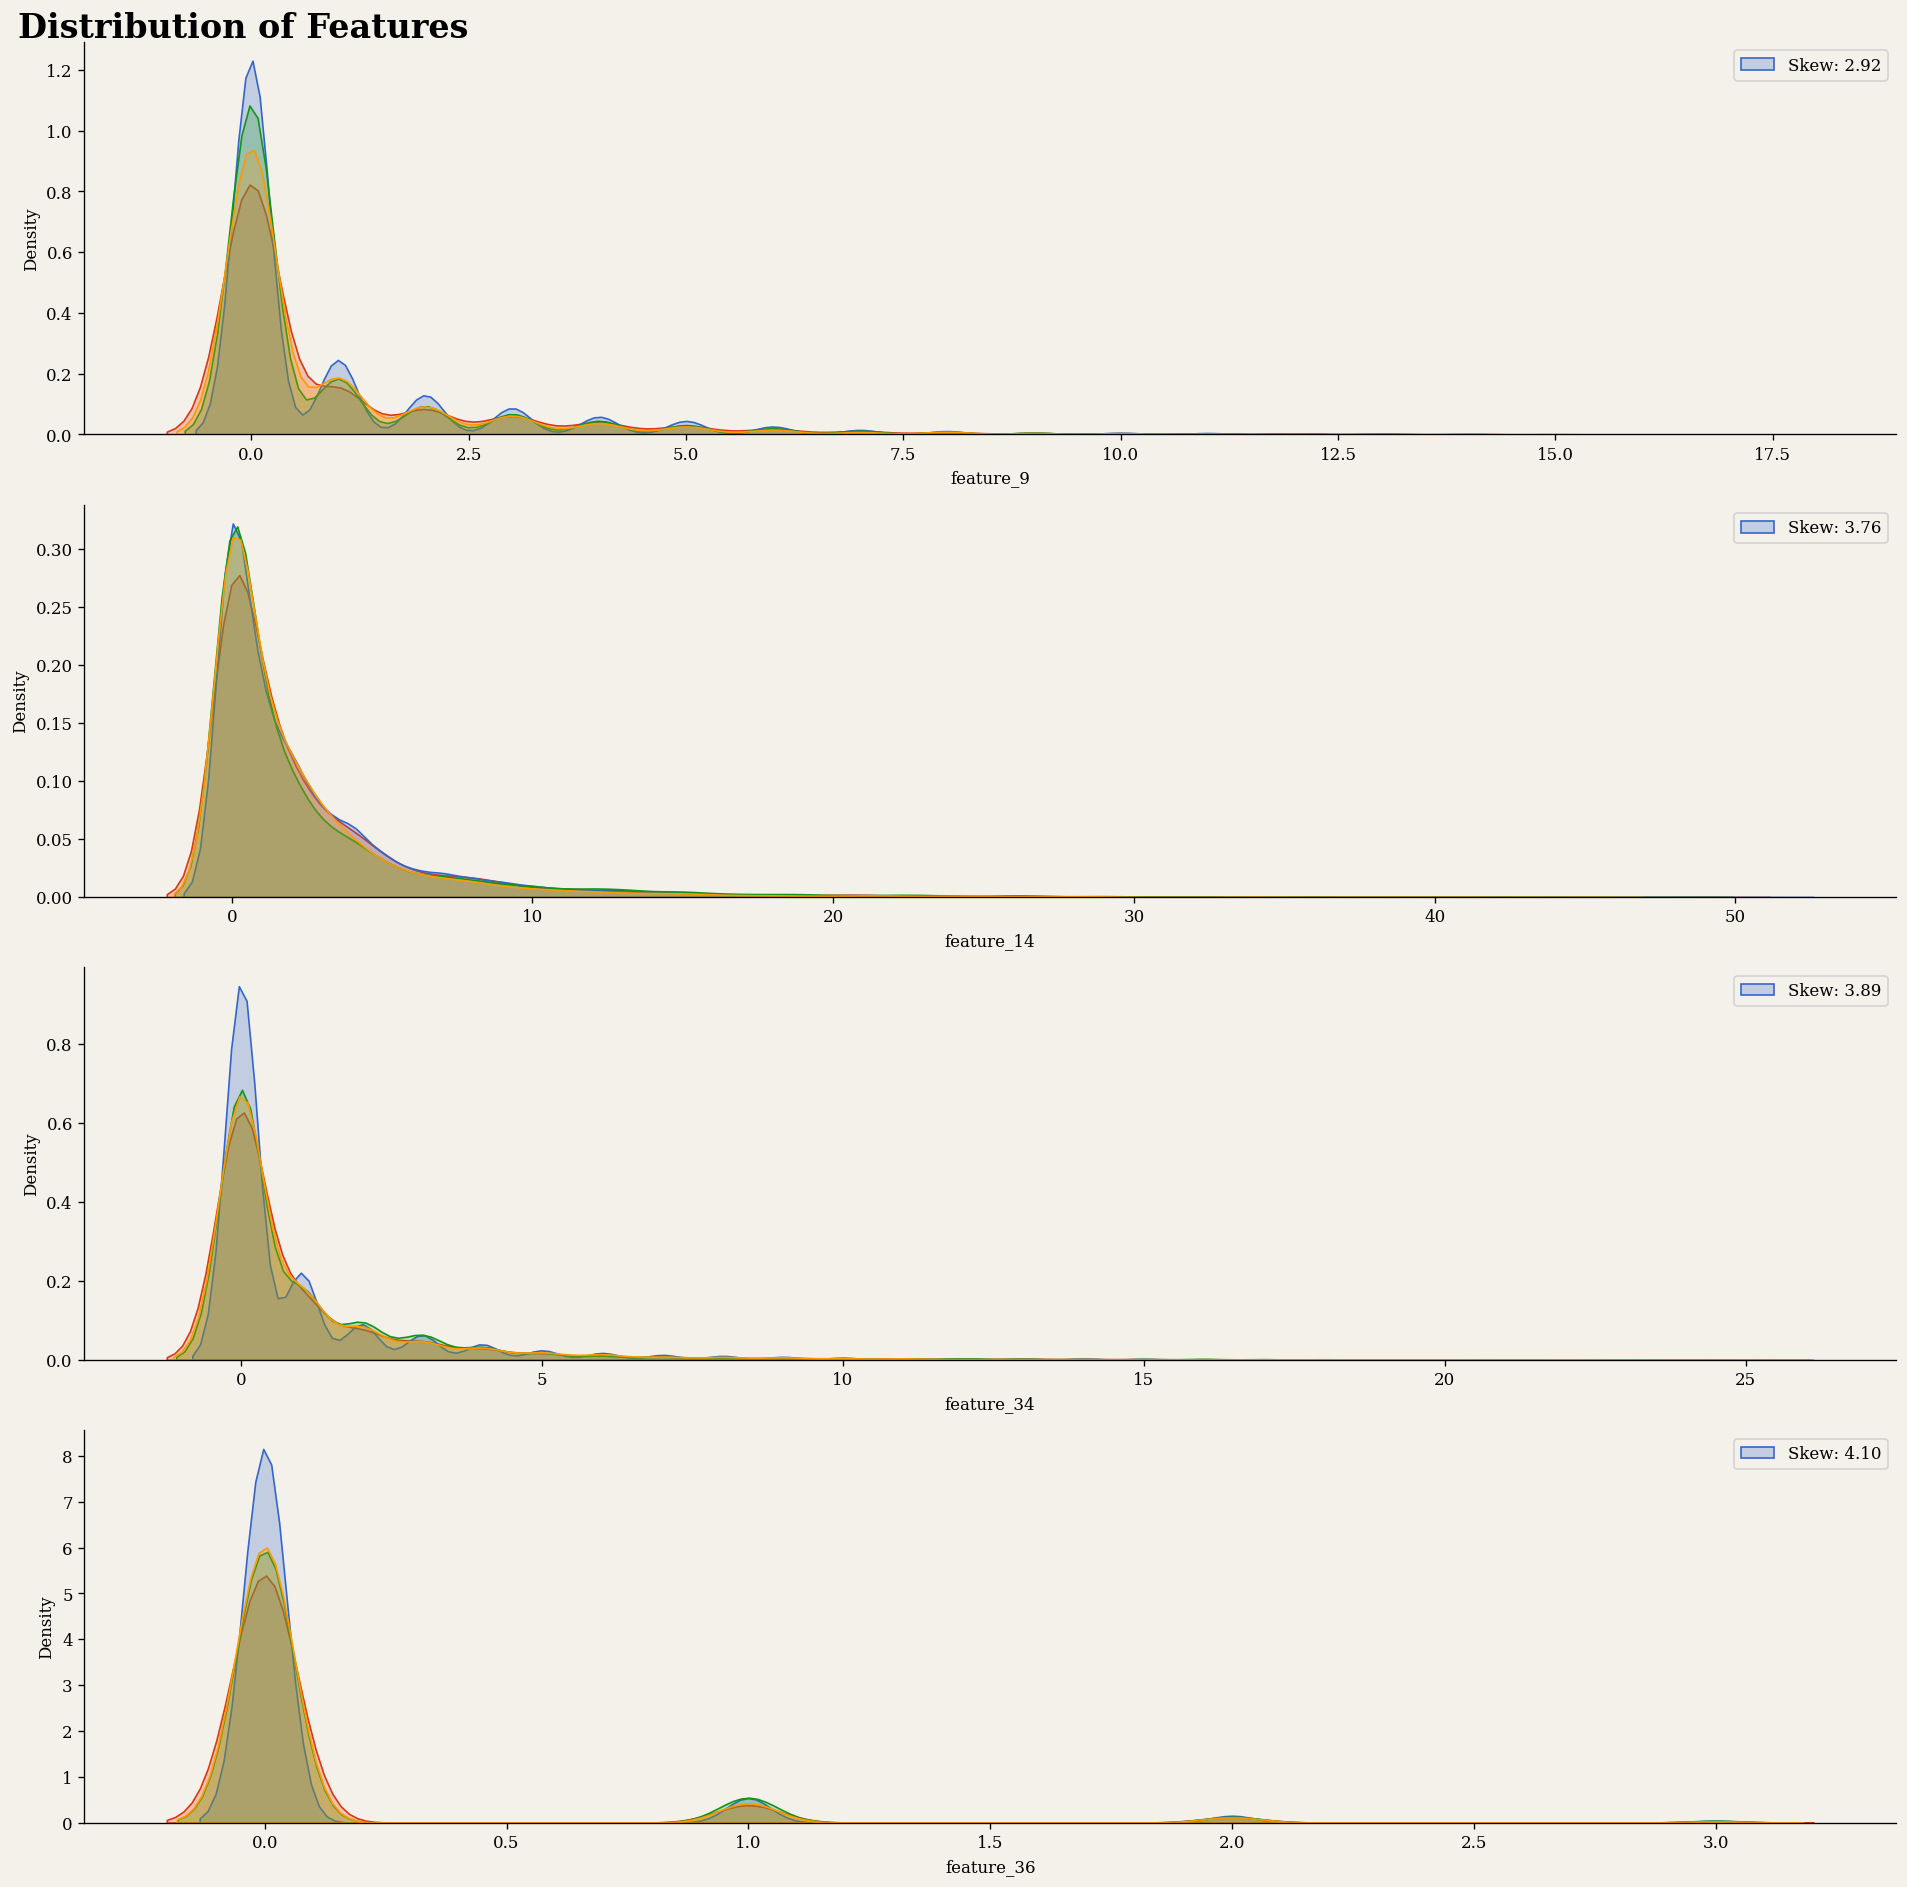

In [24]:
columns_to_plot = ['feature_9', 'feature_14', 'feature_34', 'feature_36']

num_rows, num_cols = len(columns_to_plot),1
f, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 16), facecolor=primary_bgcolor)
f.suptitle('Distribution of Features', fontsize=20, fontweight='bold', fontfamily='serif', x=0.13)


for index, column in enumerate(train_df[columns_to_plot].columns):
    i,j = (index // num_cols, index % num_cols)
    g = sns.kdeplot(train_df.loc[train_df[target_column] == 'Class_1', column], color=px.colors.qualitative.G10[1], shade=True, ax=axes[i])
    g = sns.kdeplot(train_df.loc[train_df[target_column] == 'Class_2', column], color=px.colors.qualitative.G10[0], label="Skew: %.2f"%(train_df[column].skew()), shade=True, ax=axes[i])
    g = g.legend(loc="best")
    sns.kdeplot(train_df.loc[train_df[target_column] == 'Class_3', column], color=px.colors.qualitative.G10[3], shade=True, ax=axes[i])
    sns.kdeplot(train_df.loc[train_df[target_column] == 'Class_4', column], color=px.colors.qualitative.G10[2], shade=True, ax=axes[i])

# f.delaxes(axes[-1, -1])
plt.tight_layout()
plt.show()


In [ ]:
corr = train_df[feature_columns].corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig, ax = plt.subplots(figsize=(12, 12), facecolor=primary_bgcolor)
ax.text(-1.1, -0.7, 'Correlation between the Features', fontsize=20, fontweight='bold', fontfamily='serif')
ax.text(-1.1, 0.2, 'There is no features that pass 0.02 correlation within each other', fontsize=13, fontweight='light', fontfamily='serif')


# plot heatmap
sns.heatmap(corr, mask=mask, annot=False, fmt=".2f", cmap='coolwarm',
            cbar_kws={"shrink": .8}, vmin=0, vmax=0.05)
# yticks
plt.yticks(rotation=0)
plt.show()

# Dimension Reduction

In [25]:
# Take a subsample to reduce computational cost
train_sub = train_df.sample(1000, random_state=2021)

In [26]:
umap_2d = UMAP(n_components=2, random_state=2021)
proj_2d = umap_2d.fit_transform(train_sub[feature_columns])

In [27]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1, 
    labels={'color': 'target'},
    color=train_sub.target,
    color_discrete_sequence=px.colors.qualitative.G10,
)
fig_2d.update_layout(
    title='<span style="font-size:24px; font-family:Serif">UMAP</span>',
)

fig_2d.show()

In [28]:
tsne = TSNE(n_components=2, random_state=2021)
projections = tsne.fit_transform(train_sub[feature_columns])

In [29]:
fig = px.scatter(
    projections, x=0, y=1,
    labels={'color': 'target'},
    color=train_sub.target,
    color_discrete_sequence=px.colors.qualitative.G10,
)
fig.update_layout(
    title='<span style="font-size:24px; font-family:Serif">t-SNE</span>',
)

fig.show()

In [30]:
tsne = TSNE(n_components=3, random_state=2021)
projections = tsne.fit_transform(train_sub[feature_columns], )

In [31]:
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=train_sub.target, labels={'color': 'target'}
)
fig.update_traces(marker_size=8)
fig.show()

# H20 AutoML

In [32]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpa3j_sff0
  JVM stdout: /tmp/tmpa3j_sff0/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpa3j_sff0/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,2 months
H2O_cluster_name:,H2O_from_python_unknownUser_82go25
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.672 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [33]:
%%time

train_hf = h2o.H2OFrame(train_df.copy())
test_hf = h2o.H2OFrame(test_df.copy())

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
CPU times: user 3.01 s, sys: 140 ms, total: 3.15 s
Wall time: 8.02 s


In [35]:
train_hf[target_column] = train_hf[target_column].asfactor()

In [36]:
%%time

aml = H2OAutoML(
    seed=2021, 
    max_runtime_secs=10 * 60,
    nfolds = 3,
    exclude_algos = ["DeepLearning"]
)

aml.train(
    x=list(feature_columns), 
    y=target_column, 
    training_frame=train_hf
)

AutoML progress: |████████████████████████████████████████████████████████| 100%
CPU times: user 2min 26s, sys: 1.28 s, total: 2min 27s
Wall time: 9min 41s


In [ ]:
lb = aml.leaderboard 
lb.head(rows = lb.nrows)

In [ ]:
%%time

preds = aml.predict(h2o.H2OFrame(test_df[feature_columns].copy()))
preds_df = h2o.as_list(preds)
preds_df

submission[['Class_1', 'Class_2', 'Class_3', 'Class_4']] = preds_df[['Class_1', 'Class_2', 'Class_3', 'Class_4']]
submission.to_csv('h2o_automl_300s.csv', index=False)
submission.head()

# LightAutoML

In [37]:
!pip install -U lightautoml

In [38]:
# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from sklearn.metrics import log_loss

In [39]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 2021 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 60 * 60 # Time in seconds for automl run

In [40]:
le = LabelEncoder()
train_df[target_column] = le.fit_transform(train_df[target_column])

In [41]:
%%time 

task = Task('multiclass',)

roles = {
    'target': target_column,
    'drop': ['id'],
}


automl = TabularUtilizedAutoML(task = task, 
                               timeout = TIMEOUT,
                               cpu_limit = N_THREADS,
                               reader_params = {'n_jobs': N_THREADS},
)

oof_pred = automl.fit_predict(train_df, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 4, 'random_state': 42}
Start automl preset with listed constraints:
- time: 3599.9960849285126 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (100000, 52)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 3573.454857826233 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = -1.1129318422928451
Linear model: C = 5e-05 score = -1.1089572798199951
Linear model: C = 0.0001 score = -1.108357814656198
Linear model: C = 0.0005 score = -1.108398193243146
Linear model: C = 0.001 score = -1.108518839929998

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = -1.1124145602330566


KeyboardInterrupt: 

In [ ]:
%%time

test_pred = automl.predict(test_df)
print('Prediction for test set:\n{}\nShape = {}'.format(test_pred[:5], test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(log_loss(train_df[target_column].values, oof_pred.data)))

In [ ]:
submission.iloc[:, 1:] = test_pred.data
submission.to_csv('lightautoml_v1_1hour.csv', index = False)